# Brouillon partie d'avant 


In [2]:
import matplotlib.pyplot as plt 
import pandas as pd
import numpy as np
import seaborn as sns
from src.utils.appendix import *
from sklearn.preprocessing import MultiLabelBinarizer 
from sklearn.linear_model import LinearRegression

import geopandas as gpd
import plotly.graph_objects as go
from IPython.display import Image
from statsmodels.formula.api import ols
import pingouin as pg
from scipy.stats import kruskal
from scipy.stats import shapiro
%load_ext autoreload
%autoreload 2
from src.utils.data_cleaning2 import *
from src.utils.visualization import *
from src.utils.appendix import *
import statsmodels.api as sms
import statsmodels.api as sm
from sklearn.metrics import r2_score

In [3]:
raw_movies_data = pd.read_csv("data/MoviesDataset/movie.metadata.zip", header= None, delimiter='\t')
clean_movies_data = preprocess_movies(raw_movies_data)
processed_data_path = 'data/Preprocessed_data/preprocessed_movie_metadata.csv'
clean_movies_data.to_csv(processed_data_path, encoding='utf-8', errors='ignore', index=False)
preprocessed_movies = pd.read_csv(processed_data_path)

In [6]:
raw_history_data= pd.read_csv("data/HistoricalDataset/historical.dataset.zip")
first_movie_year = preprocessed_movies['Year'].min()
last_movie_year = preprocessed_movies['Year'].max()
cleaned_events = preprocess_events(raw_history_data, first_movie_year, last_movie_year)
events_countries = cleaned_events['Country'].unique()
movies_countries = preprocessed_movies['Countries'].str.split(', ').explode().unique()
#Elements in events_countries that are not in movies_countries
not_in_movies_dataset = [item for item in events_countries if item not in movies_countries]
cleaned_events = cleaned_events[cleaned_events['Country'].isin(movies_countries)]
preprocessed_history = cleaned_events.copy()

The baseline scenario (no events) shows the predicted probability of LGBT-themed movies over time, purely based on the time trend without external influences.
For each event (e.g., post-decriminalization of homosexuality, post-Stonewall riots, post-legalization of same-sex marriage), the graph shows the predicted probabilities with that event "turned on" at its corresponding year.

In [7]:
lgbt_events = preprocessed_history[preprocessed_history['Affected Population'].str.contains(r'lgbt', case=False, na=False)]
preprocessed_movies['is_lgbt'] = preprocessed_movies['Genres'].str.contains(r'lgbt', case=False, na=False).astype(int)

def safe_colname(name):
    return 'post_' + ''.join(e if e.isalnum() else '_' for e in name.lower())

# Create dummy variables for each LGBT-related event
for _, row in lgbt_events.iterrows():
    event_year = row['Year']
    event_name = row['Name of Incident']
    col_name = safe_colname(event_name)
    preprocessed_movies[col_name] = (preprocessed_movies['Year'] >= event_year).astype(int)

# Center the Year variable
preprocessed_movies['Year_centered'] = preprocessed_movies['Year'] - preprocessed_movies['Year'].mean()

# Define predictors: Year_centered + all event dummies
predictors = ['Year_centered']
event_dummy_cols = [col for col in preprocessed_movies.columns if col.startswith('post_')]
predictors += event_dummy_cols

# Create the X and y matrices
X = preprocessed_movies[predictors]
y = preprocessed_movies['is_lgbt']
# Drop the columna identified as perfectly correlated
if 'post_homosexual_law_reform_act' in X.columns:
    X = X.drop(columns=['post_homosexual_law_reform_act'])

if 'post_approval_of_sameunknownsex_marriage' in X.columns:
    X = X.drop(columns=['post_approval_of_sameunknownsex_marriage'])

#drop unstable column 
if 'post_sameunknownsex_marriage_legalized' in X.columns:
    X = X.drop(columns=['post_sameunknownsex_marriage_legalized'])

# Update event_dummy_cols after dropping the column
event_dummy_cols = [col for col in X.columns if col.startswith('post_')]

# Fit logistic regression
model_logit = sm.Logit(y, sm.add_constant(X)).fit()

print(model_logit.summary())

Optimization terminated successfully.
         Current function value: 0.078854
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:                is_lgbt   No. Observations:                68131
Model:                          Logit   Df Residuals:                    68126
Method:                           MLE   Df Model:                            4
Date:                Wed, 18 Dec 2024   Pseudo R-squ.:                 0.07267
Time:                        18:03:37   Log-Likelihood:                -5372.4
converged:                       True   LL-Null:                       -5793.5
Covariance Type:            nonrobust   LLR p-value:                5.897e-181
                                                   coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------
const                                  

['post_decriminalization_of_homosexuality', 'post_stonewall_riots', 'post_legalization_of_sameunknownsex_marriage']
['post_decriminalization_of_homosexuality', 'post_stonewall_riots', 'post_legalization_of_sameunknownsex_marriage']
['post_decriminalization_of_homosexuality', 'post_stonewall_riots', 'post_legalization_of_sameunknownsex_marriage']
['post_decriminalization_of_homosexuality', 'post_stonewall_riots', 'post_legalization_of_sameunknownsex_marriage']


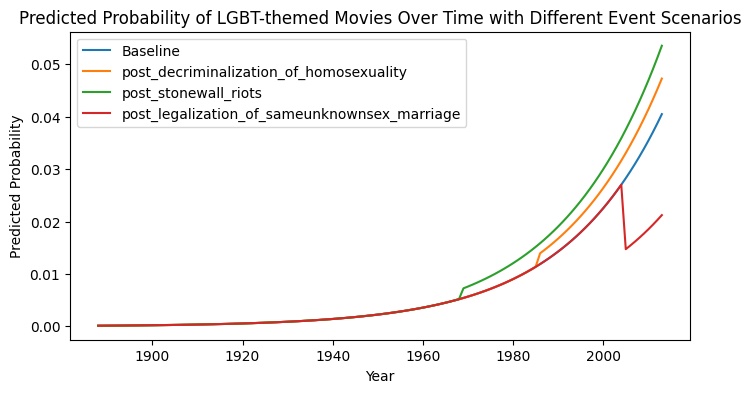

In [8]:
# Generate a range of years to predict over
years_to_plot = np.arange(preprocessed_movies['Year'].min(), preprocessed_movies['Year'].max() + 1)
plot_df = pd.DataFrame({'Year': years_to_plot})
plot_df['Year_centered'] = plot_df['Year'] - preprocessed_movies['Year'].mean()

# Identify event columns (final set you used in the model)
# Make sure these match the model you have fitted exactly.
event_dummy_cols = [
    'post_decriminalization_of_homosexuality',
    'post_stonewall_riots',
    'post_legalization_of_sameunknownsex_marriage'
]

# Function to set event dummies for a given scenario
def set_event_scenario(df, events, scenario='baseline'):
    df_scenario = df.copy()
    # Start with all events off (0)
    for ev_col in event_dummy_cols:
        df_scenario[ev_col] = 0
    
    if scenario == 'baseline':
        return df_scenario
    
    # If scenario is one event at a time
    for event in events:
        if scenario == event['col_name']:
            # This event turns on at and after event['year']
            df_scenario.loc[df_scenario['Year'] >= event['year'], event['col_name']] = 1

    return df_scenario

# Prepare scenarios
# 1) Baseline (no events)
scenarios = [('Baseline', 'baseline')]

# Define events_info
events_info = []
for col_name in event_dummy_cols:
    event_year = preprocessed_movies[preprocessed_movies[col_name] == 1]['Year'].min()
    events_info.append({'col_name': col_name, 'year': event_year})

# 2) Each event on its own
for ev in events_info:
    scenarios.append((ev['col_name'], ev['col_name']))

plt.figure(figsize=(8,4))

for label, scenario in scenarios:
    df_scenario = set_event_scenario(plot_df, events_info, scenario=scenario)
    # Construct X_scenario using the same predictors model_logit was trained on
    X_scenario = df_scenario[['Year_centered'] + event_dummy_cols]
    print(event_dummy_cols)
    X_scenario = sm.add_constant(X_scenario)  # Add the const column
    
    # Predict probabilities
    df_scenario['predicted_prob'] = model_logit.predict(X_scenario)
    
    # Plot the scenario line
    plt.plot(df_scenario['Year'], df_scenario['predicted_prob'], label=label)

plt.xlabel('Year')
plt.ylabel('Predicted Probability')
plt.title('Predicted Probability of LGBT-themed Movies Over Time with Different Event Scenarios')
plt.legend()
plt.show()